## Causal Inference

To understand potential causal relationships between lifestyle, demographic, and clinical variables and the onset of chronic diseases (Diabetes, Cardiovascular Disease, Kidney Disease), we apply several causal discovery algorithms to selected features from the NHANES dataset.

### Algorithms Used

We use three widely adopted structure learning methods for causal discovery, each with distinct assumptions and inference strategies:

1. **PC Algorithm**  
   - A constraint-based method that infers the causal structure by systematically testing for conditional independencies.
   - Assumes causal sufficiency and the faithfulness condition.
   - Returns a partially directed acyclic graph (CPDAG) representing the Markov equivalence class of DAGs.

2. **Greedy Equivalence Search (GES)**  
   - A score-based method that explores the space of equivalence classes of DAGs.
   - Optimizes a scoring criterion such as the Bayesian Information Criterion (BIC) to find the most plausible causal structure.
   - Tends to be more robust to noise in independence tests compared to constraint-based approaches.

3. **LiNGAM (Linear Non-Gaussian Acyclic Model)**  
   - A functional causal model assuming linear relationships and non-Gaussian noise.
   - Capable of inferring causal directionality from observational data, unlike methods that rely solely on conditional independence.
   - Well-suited for continuous-valued variables.

These methods are implemented using the [`causal-learn`](https://github.com/py-why/causal-learn) Python library.



---

# Diabetes

---

In [33]:
import pickle
from collections import Counter

# Step 1: Initialize a Counter to track feature appearances
feature_counter = Counter()

# Reading the dictionary from the file
with open('feature_sets_diabetes.pkl', 'rb') as f:
    loaded_feature_sets = pickle.load(f)

# Printing to verify
print(loaded_feature_sets)
for method, features in loaded_feature_sets.items():
    feature_counter.update(features)


features_in_at_least_2_methods = [feature for feature, count in feature_counter.items() if count >= 2]

features_in_at_least_2_methods = [feature for feature in features_in_at_least_2_methods if feature not in ('RXQ050', 'RXQ033')]
# Printing the result
print("Features that appeared in at least 2 methods:", features_in_at_least_2_methods)


{'Model-Based': ['LBXGH', 'DR1HELP', 'BAARFC31', 'RXQ050', 'RXQ033', 'DRD370EQ', 'BAQ321B', 'OCQ180', 'RHQ078', 'PAD800', 'DR1TALCO', 'MCQ160B', 'DRD370AQ', 'DRD370DQ', 'BAQ321C', 'LBXRDW', 'LBDGLUSI', 'BPQ080', 'LUARXNC', 'DR1TNIAC', 'WTDR2D', 'BPQ020', 'LBDBANO', 'FNQ530', 'LBDBPBSI', 'LBXTC', 'DPQ100', 'KIQ022', 'DR1TFDFE', 'SMQ770', 'DR1TVB12', 'WHD010', 'BPXOPLS2', 'DR1TP184', 'BMXARMC', 'BPQ101D', 'DR1TLZ', 'LBXES1', 'DR1TCOPP', 'DRD340', 'SMD460', 'IMQ060', 'BAXPF42', 'DR1TPHOS', 'LBXDHE', 'DRD370SQ', 'PAD810Qcombined', 'BAXTC32', 'LBXFER', 'BAARFC22'], 'Domain': ['RIDAGEYR', 'RIAGENDR', 'RIDRETH3', 'DMDEDUC2', 'INDFMMPI', 'INDFMPIR', 'BMXBMI', 'BMXWAIST', 'BMXHIP', 'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TCHOL', 'DR1TCAFF', 'DR1_320Z', 'PAD680', 'LBXGLU', 'LBDINSI', 'LBXAGP', 'LBDHDD', 'SMQ040', 'ALQ121', 'SLD012', 'SLD013', 'DPQ100', 'PAD790Qcombined', 'PAD810Qcombined'], 'Correlation': ['LBXGH', 'LBXGLU', 'LBDGLUSI', 'RXQ050', '

In [37]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz, fastkci, chisq
from sklearn.impute import KNNImputer

# Step 1: Load NHANES dataset
df = pd.read_csv("NHANES_SAMPLE.csv")  # Ensure the file path is correct
columns = features_in_at_least_2_methods + ["DIQ010"]# Load diabetes-related variable names and explanations

# Step 2: Keep only selected columns (features + target)

# Step 3: Convert DIQ010 to binary (1 = diabetes, 0 = non-diabetes)
df["DIQ010"] = df["DIQ010"].apply(lambda x: 1 if x == 1 else 0)

# Handle activity columns
activity_columns = [("PAD790Q", "PAD790U"), ("PAD810Q", "PAD810U")]  # List of pairs
for freq_col, unit_col in activity_columns:
    if freq_col in df.columns and unit_col in df.columns:
        df[f"{freq_col}combined"] = df[freq_col].astype(str) + "_" + df[unit_col].astype(str)  # Concatenate values
        df.drop([freq_col, unit_col], axis=1, inplace=True)  # Drop original columns

df = df[columns]

# Step 6: Remove constant columns (if any)
df = df.loc[:, df.nunique() > 1]

# Step 7: Convert categorical columns to numerical
for col in df.select_dtypes(include=["object", "category"]).columns:
    df[col] = df[col].astype("category").cat.codes

# Step 8: Convert dataframe to numpy array
knn_imputer = KNNImputer(n_neighbors=2)
df = df.dropna(axis=1, how='all')
df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)


data = df.to_numpy()
# Step 9: Run PC algorithm for causal discovery
cg = pc(data, alpha=0.05, indep_test=fisherz, max_condition_set=3)



/tmp/ipykernel_4042263/1228011550.py:37: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)
Depth=9, working on node 23: 100%|██████████| 24/24 [00:00<00:00, 1749.75it/s]


{'LBXGH': 'LBXGH', 'BAQ321C': 'BAQ321C', 'LBXRDW': 'LBXRDW', 'LBDGLUSI': 'LBDGLUSI', 'BPQ080': 'BPQ080', 'BPQ020': 'BPQ020', 'LBXTC': 'LBXTC', 'DPQ100': 'DPQ100', 'BPXOPLS2': 'BPXOPLS2', 'BMXARMC': 'BMXARMC', 'BPQ101D': 'BPQ101D', 'LBXDHE': 'LBXDHE', 'PAD810Qcombined': 'PAD810Qcombined', 'RIDAGEYR': 'RIDAGEYR', 'DMDEDUC2': 'DMDEDUC2', 'BMXBMI': 'BMXBMI', 'BMXWAIST': 'BMXWAIST', 'LBXGLU': 'LBXGLU', 'LBDINSI': 'LBDINSI', 'LBDHDD': 'LBDHDD', 'HUQ010': 'HUQ010', 'FNQ440': 'FNQ440', 'LBDTCSI': 'LBDTCSI', 'DIQ010': 'DIQ010'}


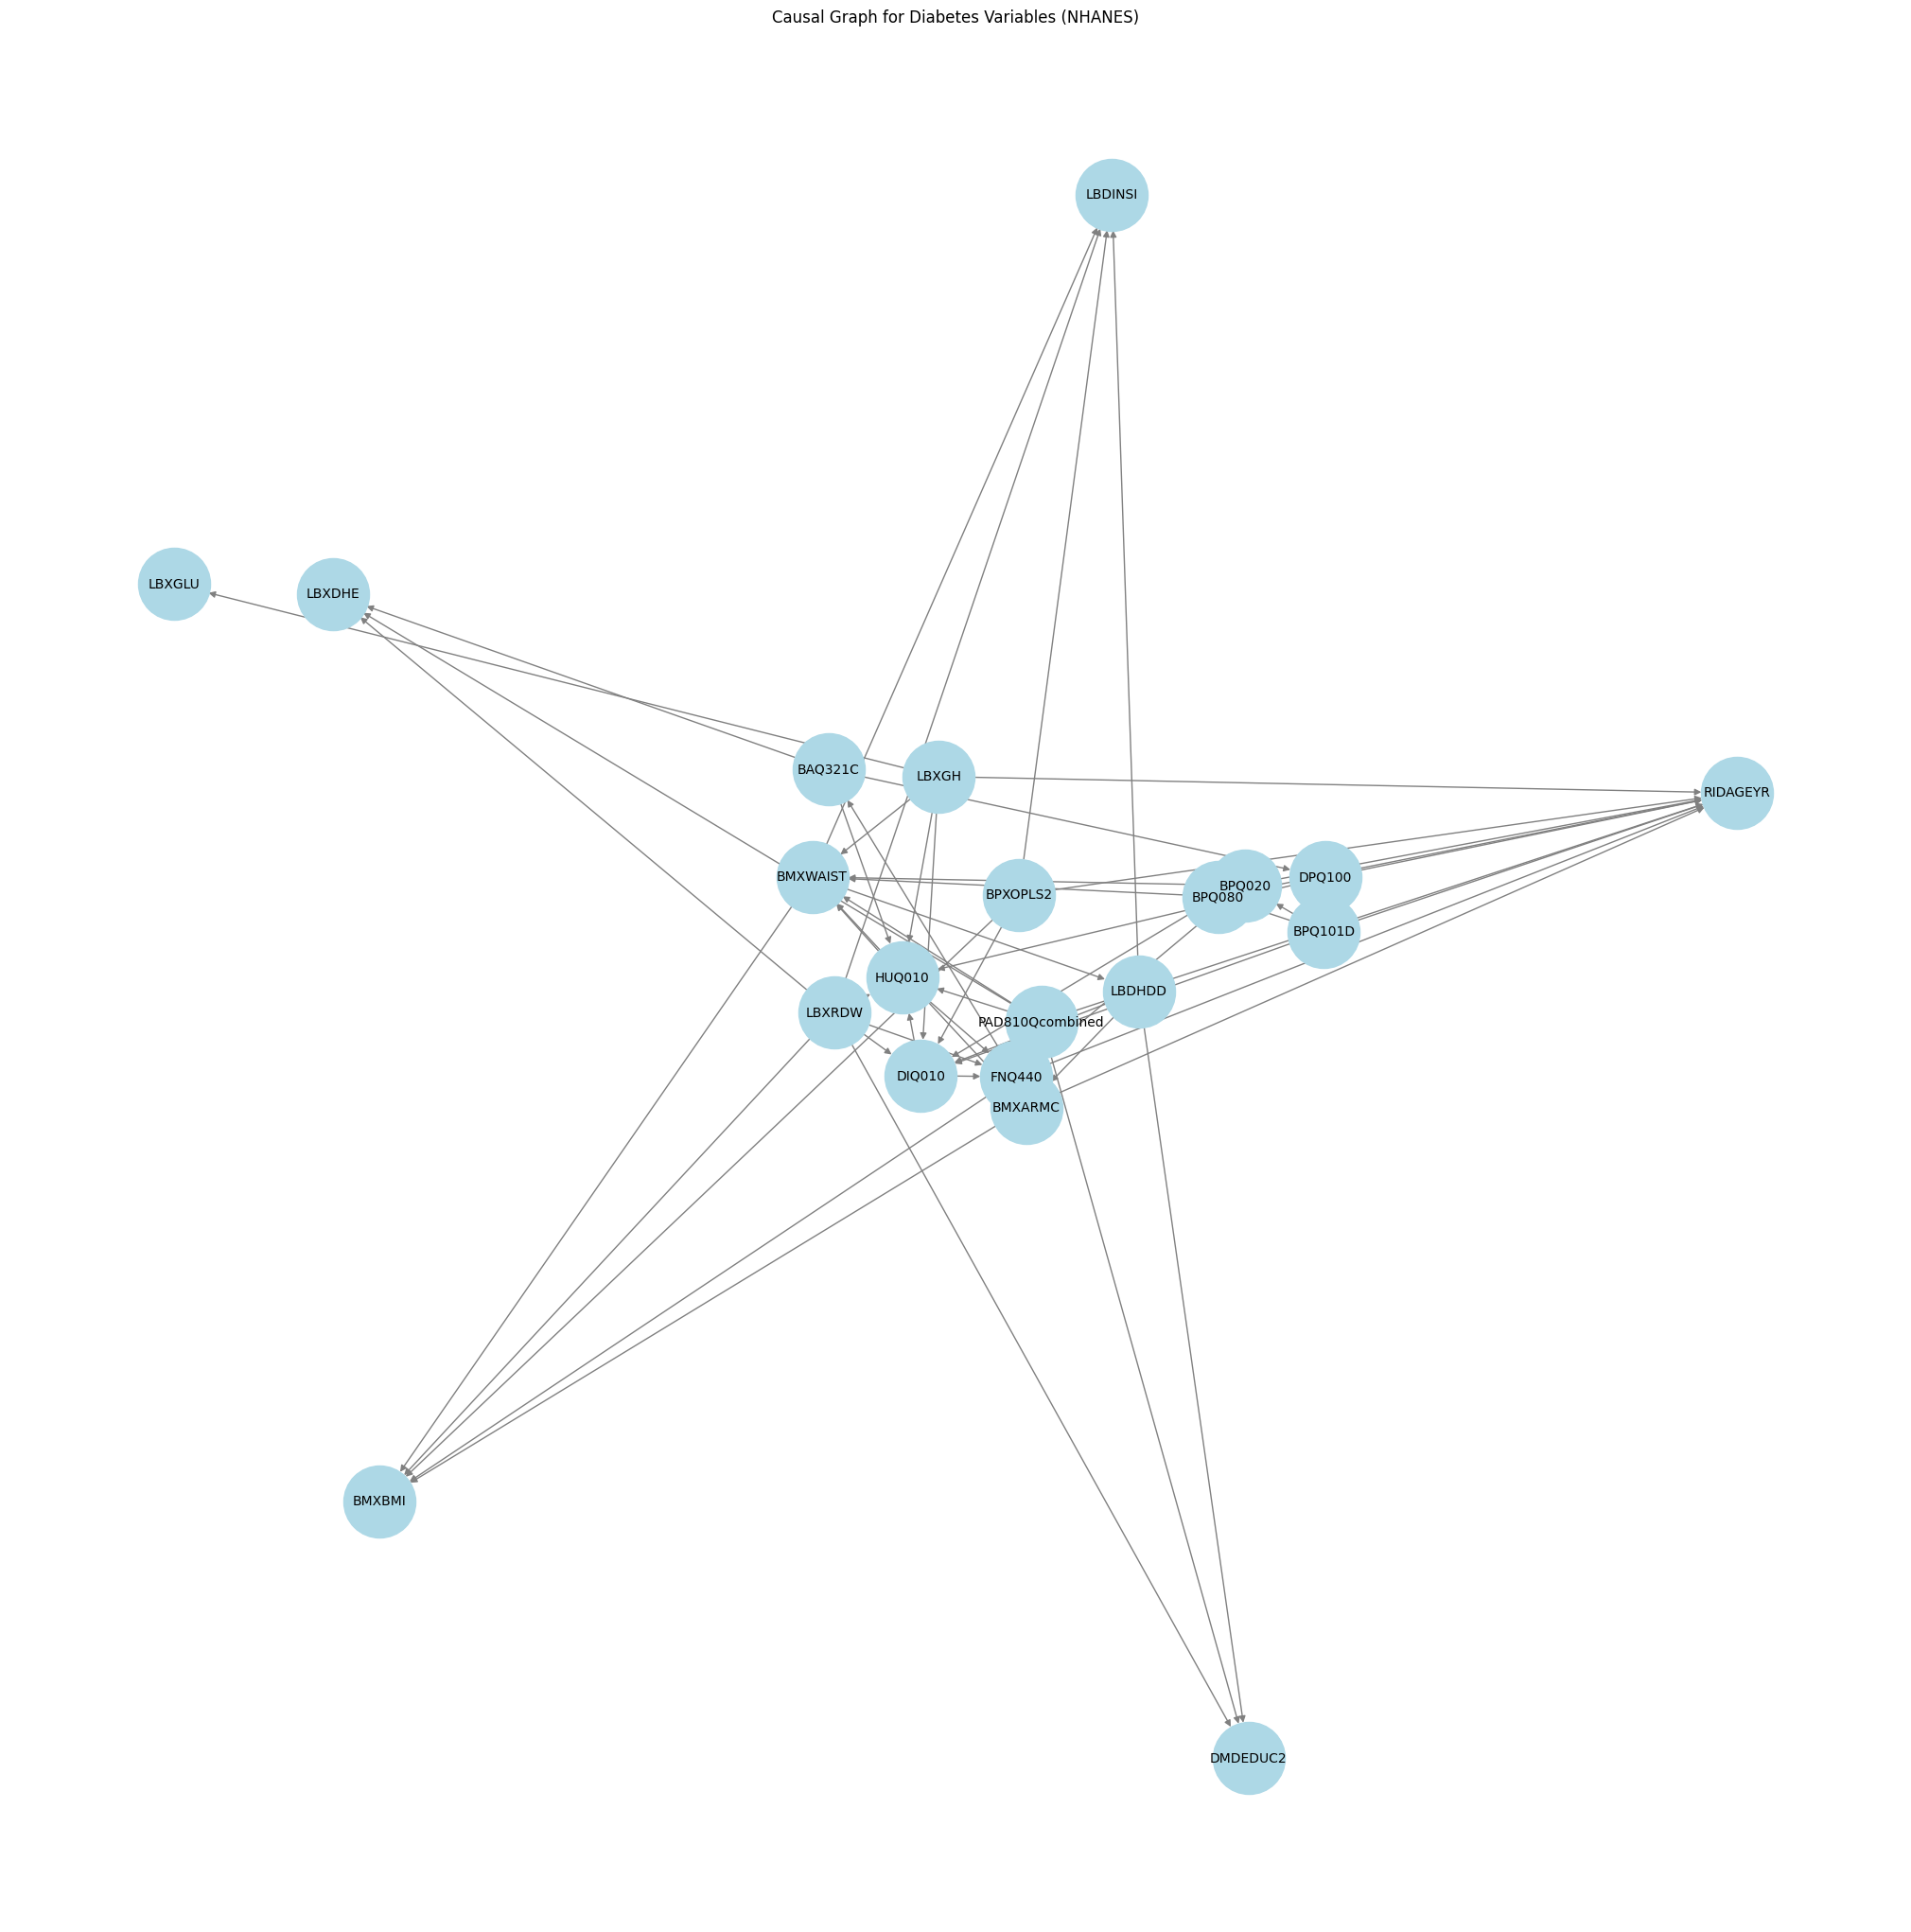

In [38]:
# Step 10: Convert causal graph to NetworkX graph
G = nx.DiGraph()  # Create a directed graph
node_labels = {col: col for col in df.columns}  # Map column names to themselves
print(node_labels)
# Ensure that the column names from df are correctly mapped to the graph's nodes
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if cg.G.graph[i, j] == 1:  # If there is an edge
            feature_i = df.columns[i]  # Get the feature name using the index
            feature_j = df.columns[j]  # Get the feature name using the index
            if feature_i in df.columns and feature_j in df.columns:  # Ensure the feature exists in df.columns
                G.add_edge(feature_i, feature_j)  # Add edge using column names
node_labels = {key: value for key, value in node_labels.items() if key in G.nodes}

# Step 12: Generate `pos` for visualization
pos = nx.spring_layout(G, seed=42)

# Step 13: Visualize the causal graph using column names as labels
plt.figure(figsize=(20, 20))
nx.draw(G, pos, labels=node_labels, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()


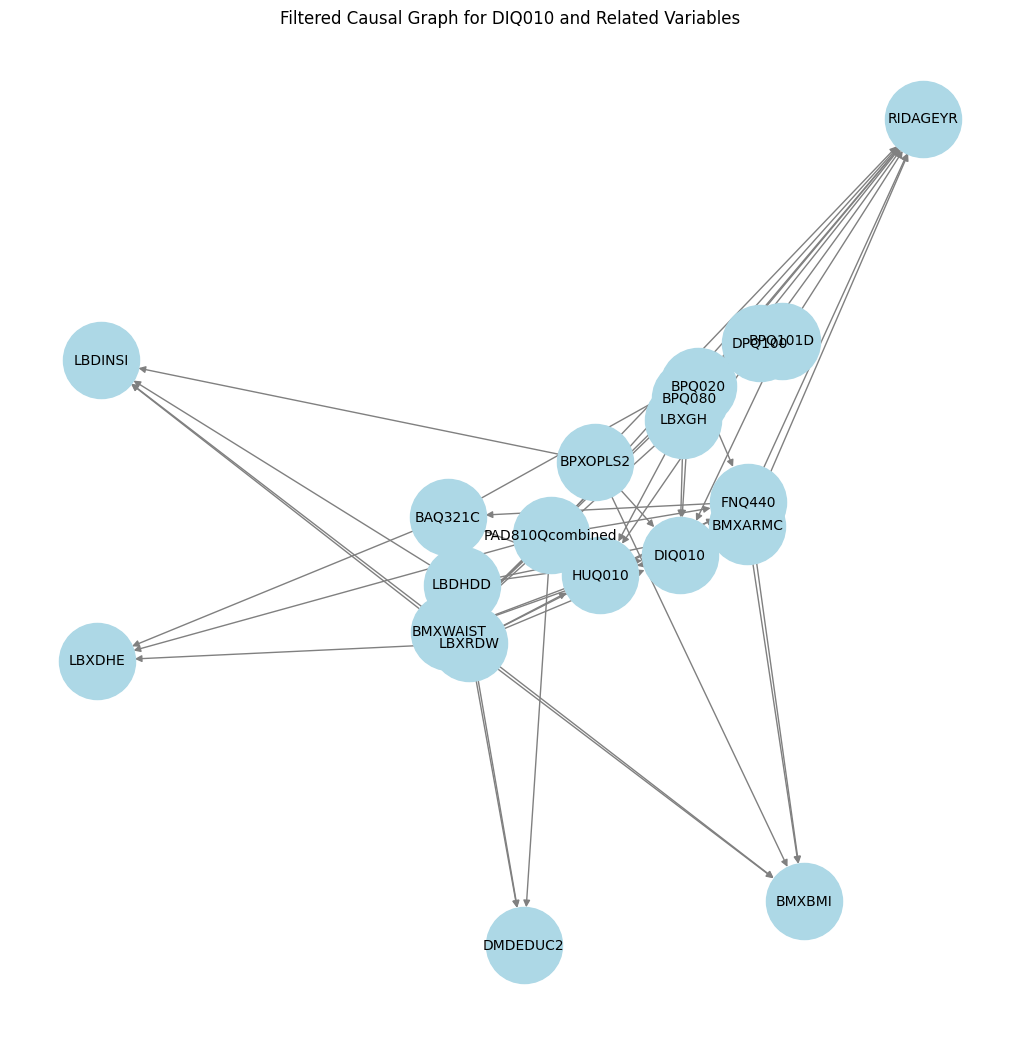

In [39]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()  # Create a directed graph
node_labels = {col: col for col in df.columns}  # Map column names to themselves

# Ensure that the column names from df are correctly mapped to the graph's nodes
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if cg.G.graph[i, j] == 1:  # If there is an edge
            feature_i = df.columns[i]  # Get the feature name using the index
            feature_j = df.columns[j]  # Get the feature name using the index
            if feature_i in df.columns and feature_j in df.columns:  # Ensure the feature exists in df.columns
                G.add_edge(feature_i, feature_j)  # Add edge using column names

# Filter the node_labels to only include nodes present in the graph
node_labels = {key: value for key, value in node_labels.items() if key in G.nodes}

# Step 1: Find all nodes related to 'DIQ010' (both direct and indirect relationships)
related_nodes = set()

# Perform BFS to find all nodes related to 'DIQ010'
if 'DIQ010' in G.nodes:
    # Add 'DIQ010' itself
    related_nodes.add('DIQ010')
    
    # Get all nodes reachable from 'DIQ010' (both forward and backward)
    forward_nodes = nx.descendants(G, 'DIQ010')  # All nodes reachable from DIQ010
    backward_nodes = nx.ancestors(G, 'DIQ010')  # All nodes that can reach DIQ010
    
    # Combine forward and backward nodes
    related_nodes.update(forward_nodes)
    related_nodes.update(backward_nodes)

# Step 2: Create a subgraph with only the related nodes
subgraph = G.subgraph(related_nodes)

# Step 3: Update node_labels for the filtered subgraph
node_labels = {key: value for key, value in node_labels.items() if key in subgraph.nodes}

# Step 4: Generate `pos` for visualization
pos = nx.spring_layout(subgraph, seed=42)

# Step 5: Visualize the filtered causal graph with only related nodes to 'DIQ010'
plt.figure(figsize=(10, 10))
nx.draw(subgraph, pos, labels=node_labels, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Filtered Causal Graph for DIQ010 and Related Variables")
plt.show()



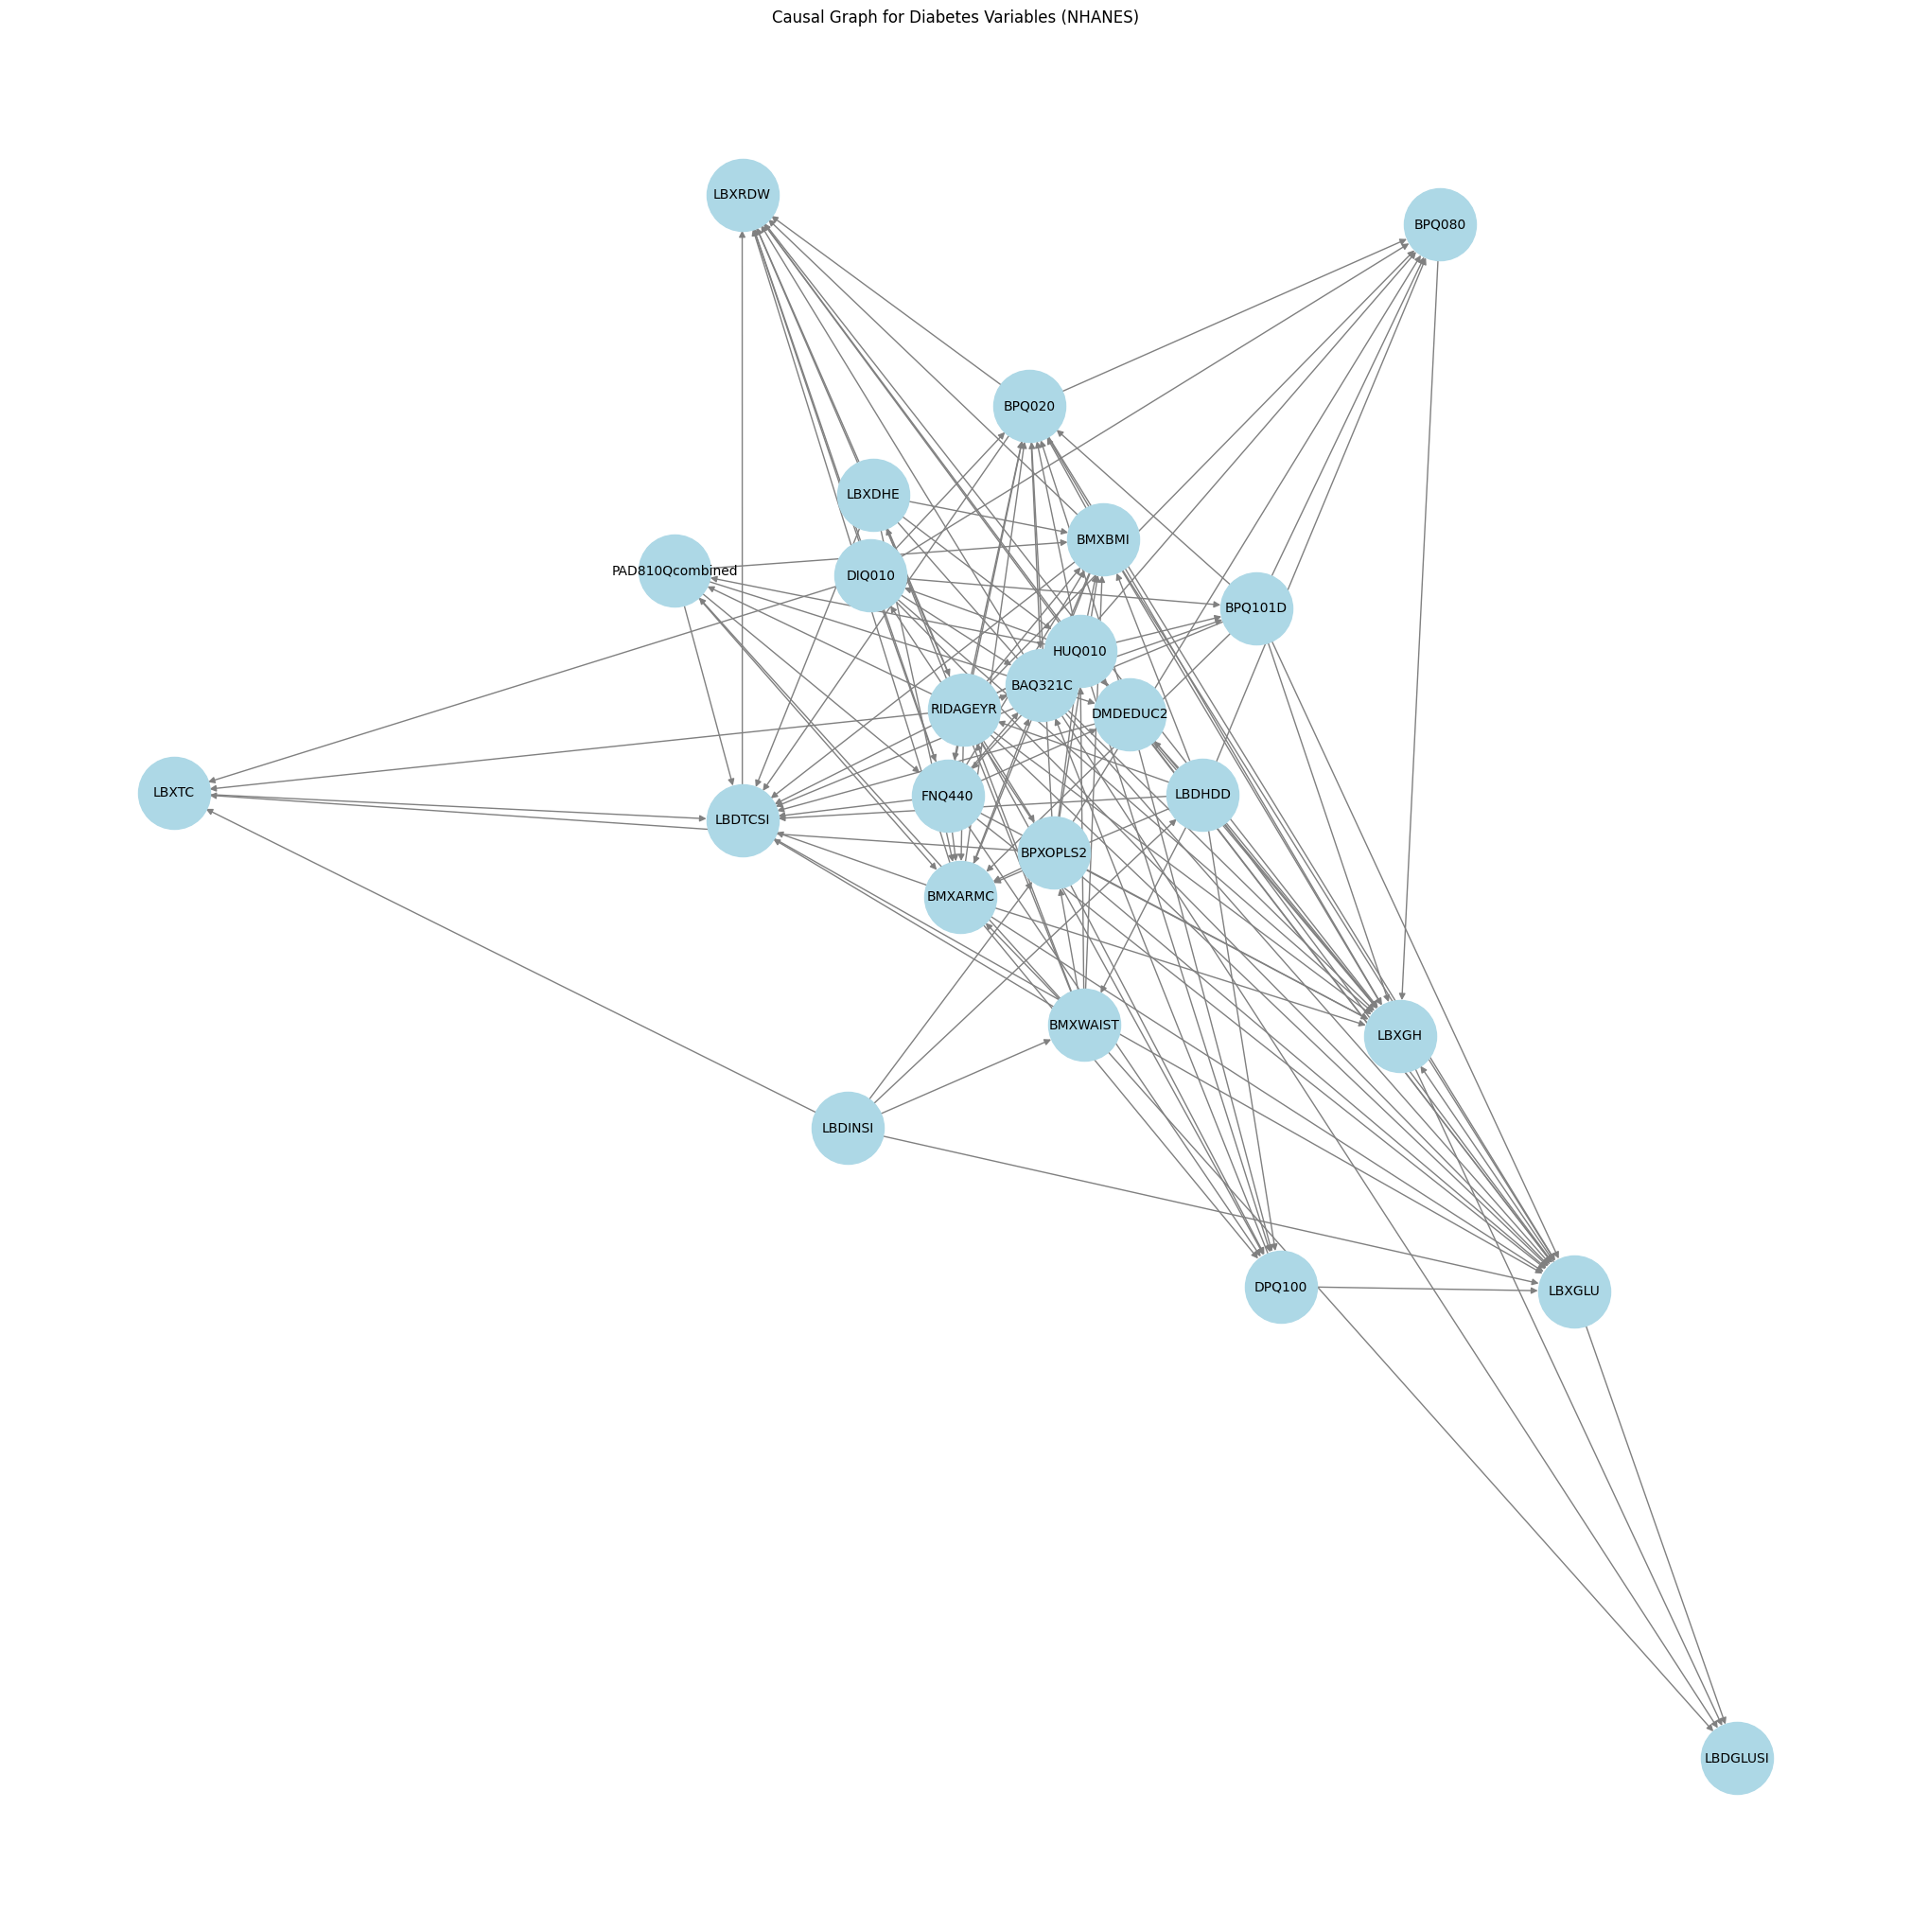

In [40]:
from causallearn.search.FCMBased import lingam

lingam = lingam.ICALiNGAM( random_state=1)
lingam.fit(data)

# Step 10: Get the causal graph from the learned coefficients
edges = lingam.adjacency_matrix_  # This gives you the adjacency matrix representing the causal graph

# Step 11: Convert causal graph to NetworkX graph
G = nx.DiGraph()  # Create a directed graph
node_labels = {col: col for col in df.columns}  # Use column names as node labels

# Add edges to the graph
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if edges[i, j] != 0:  # If there is a causal relationship
            G.add_edge(df.columns[i], df.columns[j])  # Add edge from column i to column j

# Step 12: Generate `pos` for visualization
pos = nx.spring_layout(G, seed=42)

# Step 13: Visualize the causal graph using column names as labels
plt.figure(figsize=(20, 20))
nx.draw(G, pos, labels=node_labels, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()


In [44]:
from causallearn.search.ScoreBased.GES import ges


ges = ges(data)


AttributeError: 'dict' object has no attribute 'G'

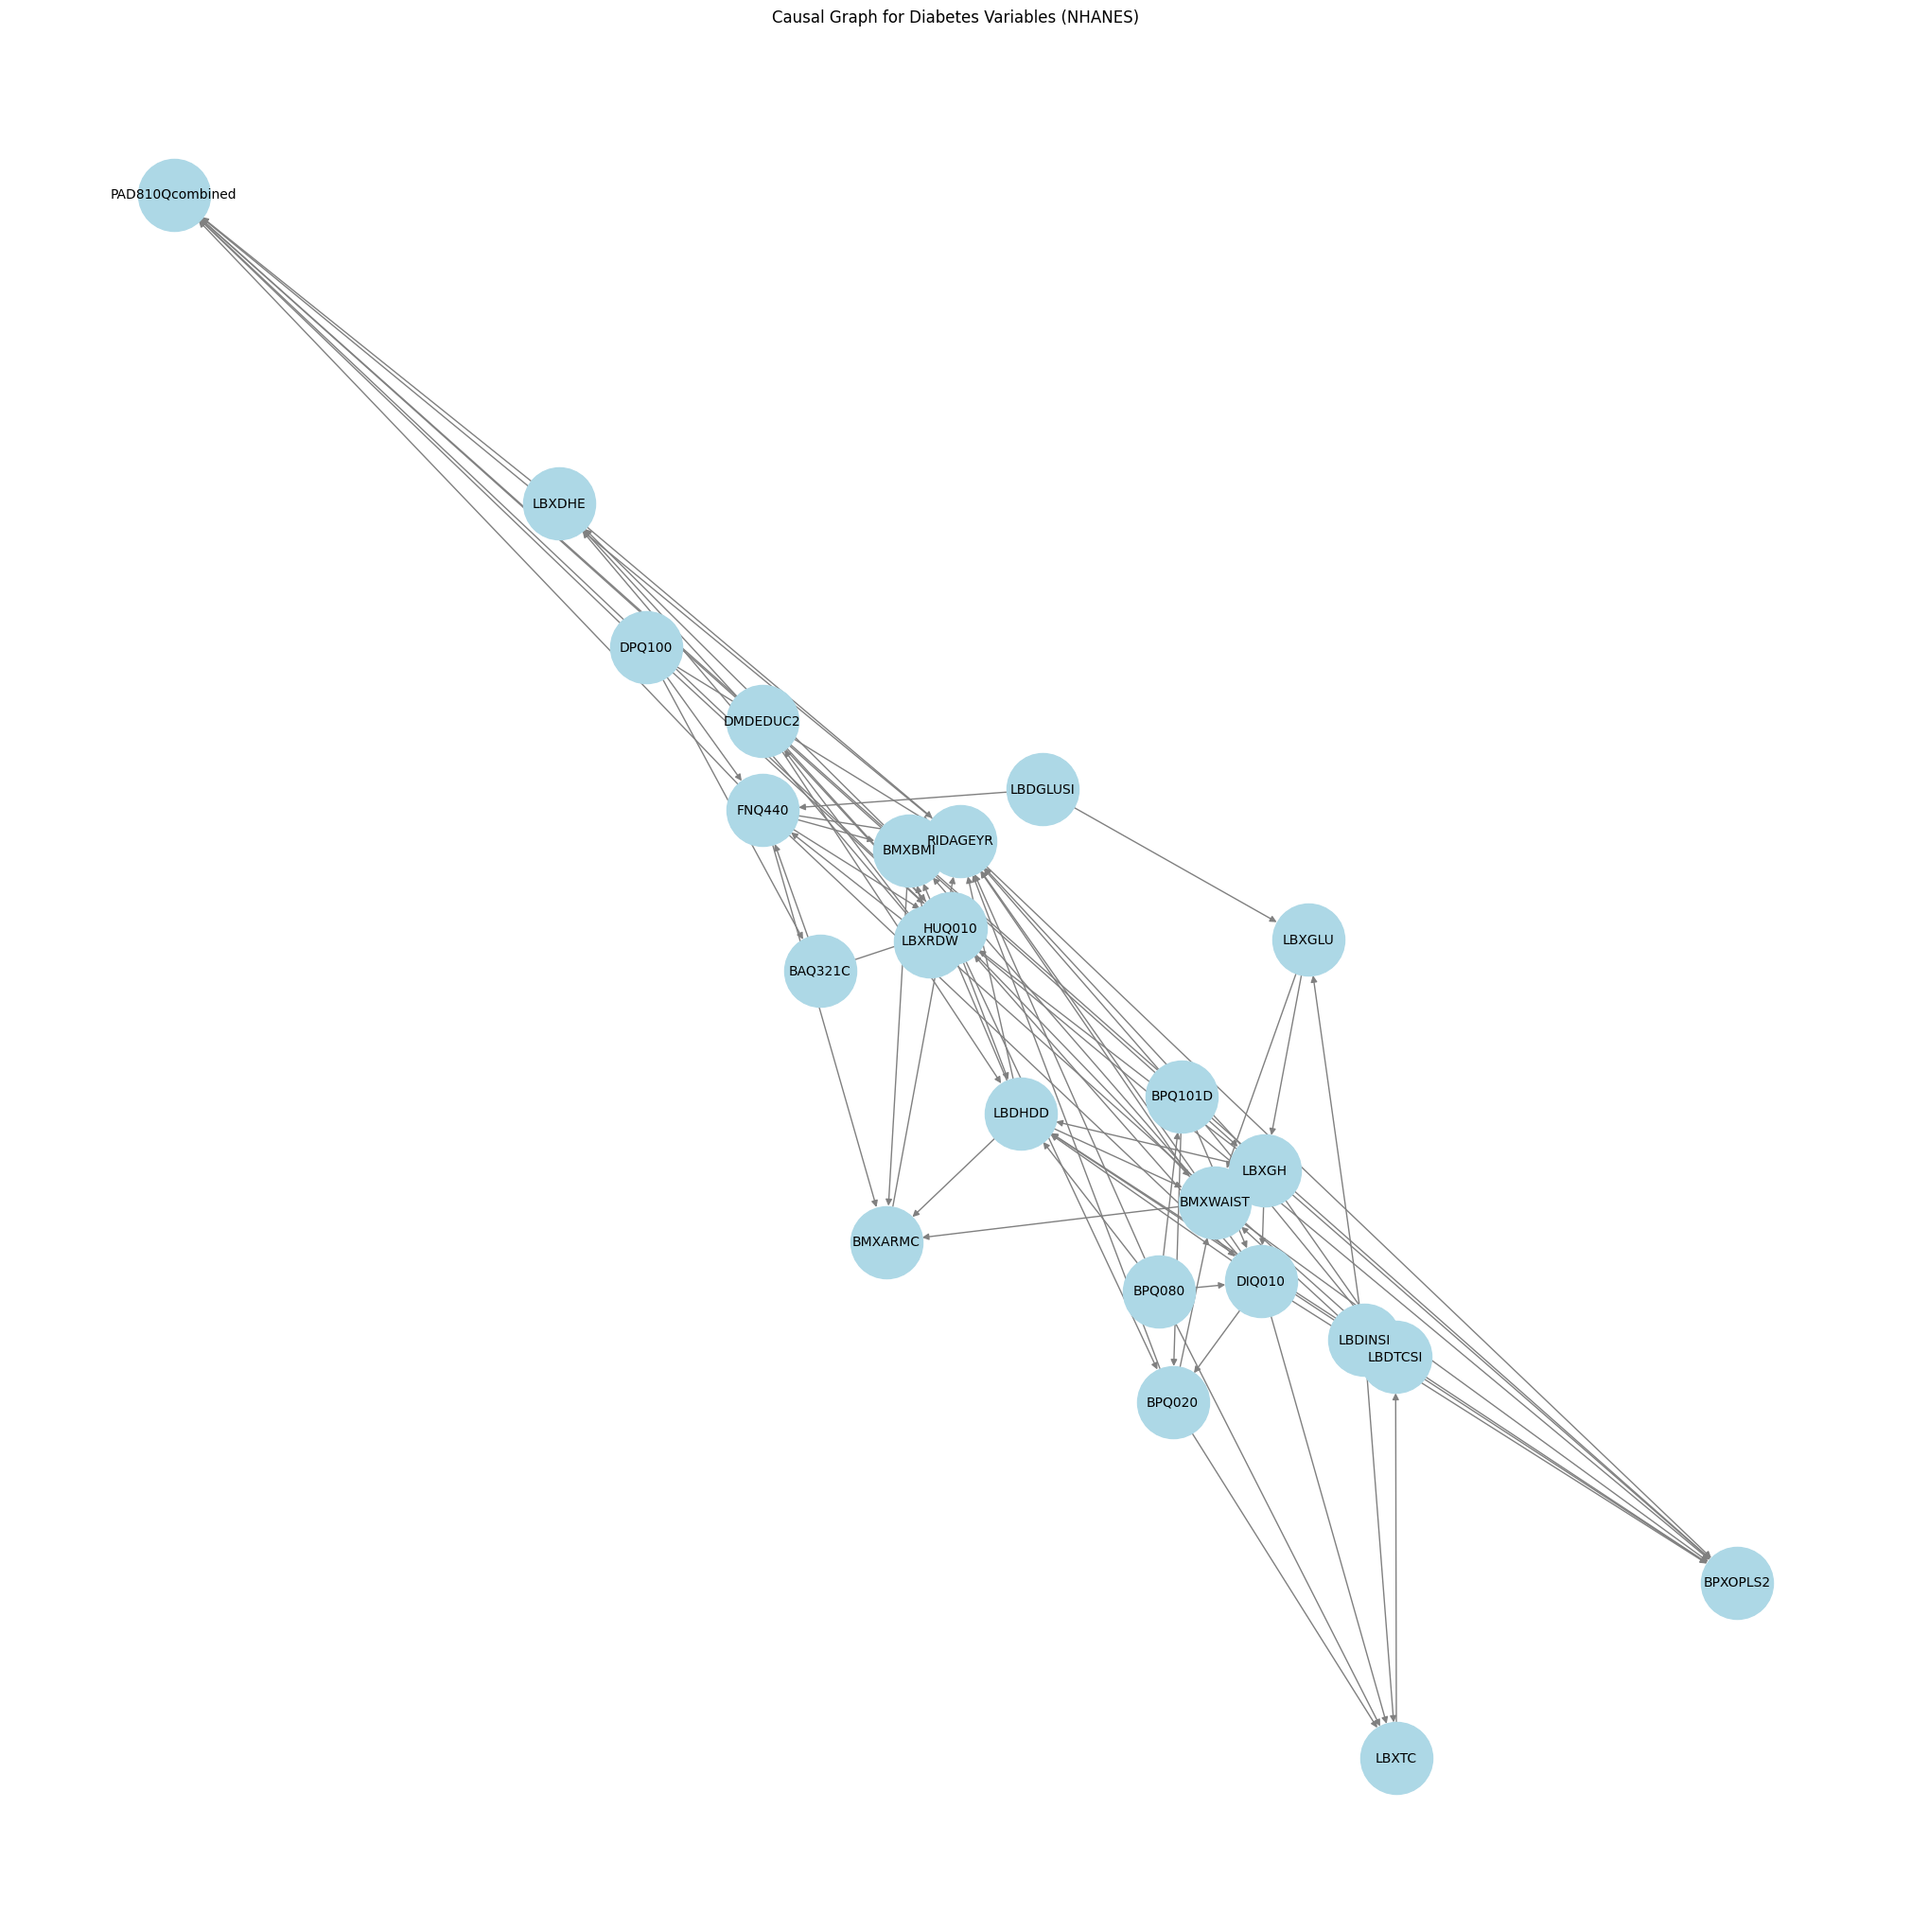

In [46]:

edges = ges["G"].graph 

G = nx.DiGraph()  # Create a directed graph
node_labels = {col: col for col in df.columns}  # Use column names as node labels

# Add edges to the graph
# node_labels = {col: col for col in df.columns}  # Use column names as node labels

# Add edges to the graph
for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        if edges[i, j] == 1:  # If there is a causal relationship i → j
            G.add_edge(df.columns[i], df.columns[j])  # Add edge from column i to column j
        elif edges[i, j] == -1:  # If there is a causal relationship j → i
            G.add_edge(df.columns[j], df.columns[i])  # Add edge from column j to column i

# Step 12: Generate `pos` for visualization
pos = nx.spring_layout(G, seed=42)

# Step 13: Visualize the causal graph using column names as labels
plt.figure(figsize=(20, 20))
nx.draw(G, pos, labels=node_labels, with_labels=True, node_size=3000,
        node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Causal Graph for Diabetes Variables (NHANES)")
plt.show()


---

# CVD

---